In [1]:
import time
import pickle
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

t = time.time()

## Viewings

In [2]:
def read_pickle(filename: str): 
    '''Read pickle to get the info'''
    list_pickle =  pickle.load(open(filename,"rb"))
    return list_pickle

In [3]:
train_tf_idf = read_pickle('train_tf_idf.pickle')
dev_tf_idf = read_pickle('dev_tf_idf.pickle')
test_tf_idf = read_pickle('test_tf_idf.pickle')

In [4]:
train_tf_idf[0]

('1185869',
 'D3303349',
 array([ 2.07415911e-02, -7.17152986e-04, -6.31216485e-03, -4.27032683e-03,
         4.35833326e-03, -9.08580645e-03, -3.50218277e-03,  1.26515626e-03,
         3.15118922e-03, -4.90558052e-03, -4.04310867e-03, -2.63131736e-03,
        -4.65671496e-04, -5.37873487e-03, -1.52014676e-03, -4.93933866e-03,
        -3.14516417e-03, -6.12237960e-03, -1.15874512e-02, -5.01716299e-03,
        -7.55584360e-03,  6.19215198e-03,  3.00399231e-03,  4.11817527e-03,
        -3.48978365e-03, -7.15885971e-03, -4.07361311e-03, -3.92740627e-03,
        -7.65330268e-04, -2.42828627e-03, -7.51175400e-03, -1.11919610e-02,
        -3.19254599e-03,  3.66403577e-03,  5.58293151e-03, -4.00348838e-03,
         1.55493098e-03, -9.62339232e-03, -2.19027107e-03,  7.37750700e-03,
        -4.47294225e-03,  1.01759974e-02, -8.62996391e-03, -1.69250255e-03,
         1.78469138e-03,  8.89994908e-04,  1.06963735e-02, -1.60244461e-03,
        -1.10804385e-02, -2.61222613e-03, -2.44291330e-03, -2.7

In [5]:
(len(train_tf_idf), len(dev_tf_idf), len(test_tf_idf))

(734026, 10386, 32516)

In [6]:
(len(test_tf_idf[0][2]), len(test_tf_idf[0][3]))

(100, 100)

In [7]:
def bool_list(batch):
    '''Input : train_tf_idf or dev_tf_idf or test_tf_idf
    Output: list of integers corresponding to Y vector, 0 for False, 1 for True'''
    list_bool = [list(elem[4]) for elem in batch]
    preprocessed_list_bool = []
    for boolean in list_bool:
        if boolean == [False]:
            preprocessed_list_bool.append(0)
        elif boolean ==[1]:
            preprocessed_list_bool.append(1)
        else:
            preprocessed_list_bool.append(int(boolean[0]))
    return preprocessed_list_bool

<AxesSubplot:ylabel='count'>

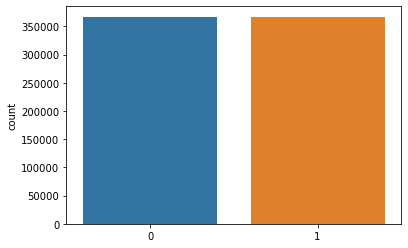

In [8]:
sns.countplot(x=bool_list(train_tf_idf))

<AxesSubplot:ylabel='count'>

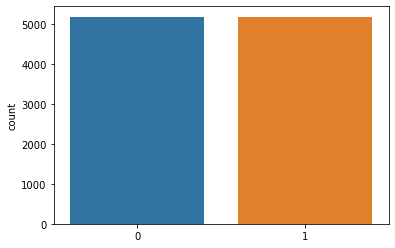

In [9]:
sns.countplot(x=bool_list(dev_tf_idf))

<AxesSubplot:ylabel='count'>

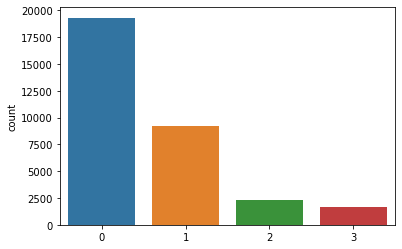

In [10]:
sns.countplot(x=bool_list(test_tf_idf))

There is some strange values in test_tf_idf (2 and 3) should I consider them as 1 ? I will assume that.

## Modelisation

In [11]:
def get_X_vectors(batch):
    '''Input : batch
    Output : Array of vectors'''
    X = []
    for i in range(len(batch)):
        X.append(np.concatenate((batch[i][2], batch[i][3])))
    return np.array(X)       

In [12]:
X_train = get_X_vectors(train_tf_idf)
X_train.shape

(734026, 200)

In [13]:
X_test = get_X_vectors(test_tf_idf)
X_test.shape

(32516, 200)

In [14]:
def get_y_vector(batch): 
    '''Input : batch
    Output : array of integers (0 or 1)'''
    list_bool = [list(elem[4]) for elem in batch]
    preprocessed_list_bool = []
    for boolean in list_bool:
        if boolean == [False]:
            preprocessed_list_bool.append(0)
        else:
            preprocessed_list_bool.append(1)
    return np.array(preprocessed_list_bool)

In [15]:
y_train = get_y_vector(train_tf_idf)
y_train.size

734026

In [16]:
y_test = get_y_vector(test_tf_idf)
y_test.size

32516

In [17]:
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression()
space = dict()
space['C'] = np.logspace(-3,3,5)
space['penalty'] = ['l1', 'l2']
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']

search = GridSearchCV(model, space, scoring='f1', n_jobs=3, cv=5)

result = search.fit(X_train, y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5837796955098382
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


In [18]:
logreg = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("F1-score:",metrics.f1_score(y_test, y_pred))

F1-score: 0.5250551152952392


In [21]:
y_pred_scores = logreg.predict_proba(X_test)
y_pred_scores

array([[0.54109618, 0.45890382],
       [0.29357027, 0.70642973],
       [0.48780036, 0.51219964],
       ...,
       [0.41790516, 0.58209484],
       [0.64916564, 0.35083436],
       [0.46112275, 0.53887725]])

In [27]:
# Creating a pickle of results
def LR_results(batch, y_pred_scores):
    if len(batch)!=len(y_pred_scores):
        raise ValueError('Array are not of the same size')
        
    LR_results = [(batch[i][0], batch[i][1], y_pred_scores[i, 0]) for i in range(len(batch))]
    return LR_results  

In [28]:
results = LR_results(test_tf_idf, y_pred_scores)
results[0:5]

[('156493', 'D1029136', 0.5410961845086448),
 ('156493', 'D399176', 0.29357026500458183),
 ('156493', 'D2688238', 0.4878003618427419),
 ('156493', 'D2079064', 0.4462382832838292),
 ('156493', 'D3425535', 0.3401004284973864)]

In [29]:
outfile = open('LR_results.pickle', 'wb')
pickle.dump(results, outfile)
outfile.close()

In [19]:
print(f"Execution time : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Execution time : 00:28:13
